In [1]:
import matplotlib.pyplot as plt
from backend import *
import numpy as np
from jax import config
config.update('jax_platform_name', 'cpu')

In [2]:
envsize = 1
startcoord = [-0.75]
goalcoord = [0.5]

npc = 13
seed = 0
episodes = 50000
goalsize = 0.025

actor_eta = 0.0001
pc_eta = 0.0001
sigma_eta = 0.000
constant_eta = 0.0001
ba = 0.0
bs = 0.0

exptname = f'1D_a2c_{npc}n_{seed}s_{episodes}e_{goalsize}gs_{actor_eta}plr_{pc_eta}llr_{constant_eta}alr_{sigma_eta}slr_{ba}ba_{bs}bs'
[logparams, allcoords, latencys, losses] = saveload('./data/'+exptname, 1, 'load')

2024-06-23 23:39:32.346091: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



28.599999999999987
-0.702640983462334


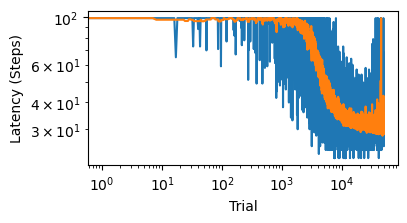

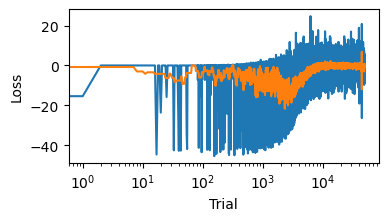

In [3]:
plt.figure(figsize=(4,2))
plt.plot(latencys)
ma = moving_average(latencys, 20)
plt.plot(ma)
plt.xlabel('Trial')
plt.ylabel('Latency (Steps)')
print(ma[-1])
plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(4,2))
plt.plot(losses)
mal = moving_average(losses, 20)
plt.plot(mal)
plt.xlabel('Trial')
plt.ylabel('Loss')
print(mal[-1])
plt.xscale('log')

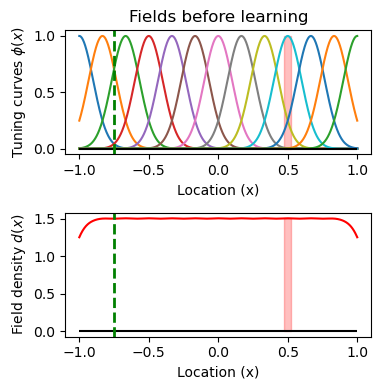

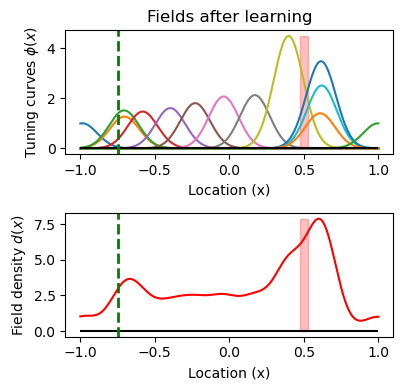

In [4]:
# plot fields before and after learning

initpcacts = plot_place_cells(logparams[0], startcoord=startcoord, goalcoord=goalcoord,goalsize=goalsize, title='Fields before learning',envsize=envsize)

pcacts = plot_place_cells(logparams[-1], startcoord=startcoord, goalcoord=goalcoord,goalsize=goalsize, title='Fields after learning',envsize=envsize)


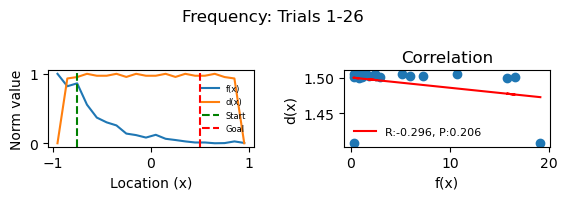

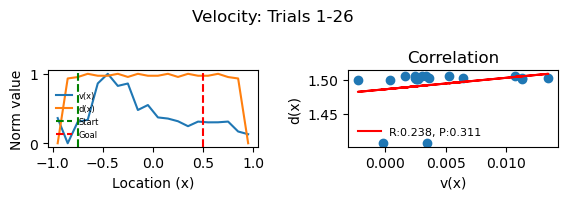

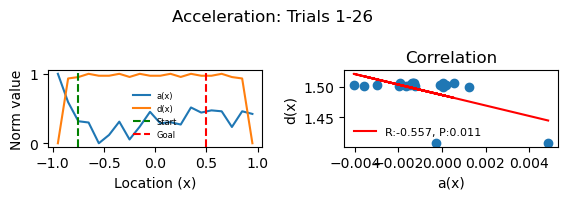

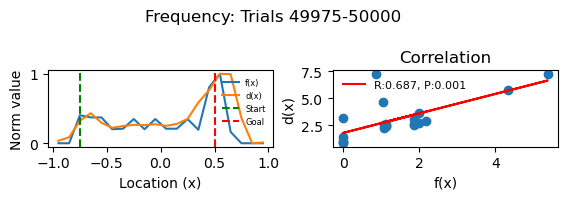

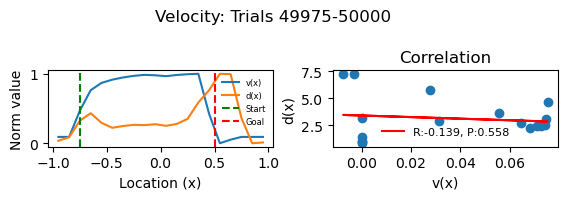

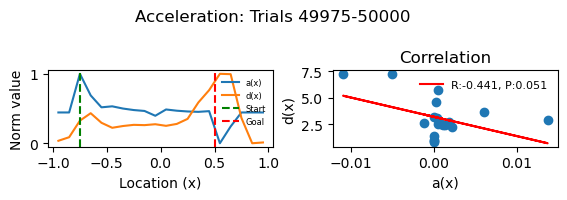

In [5]:
end = gap = 25
bins = 21
num = 31
trials = np.logspace(np.log10(end), np.log10(episodes), num, dtype=int)+1

visits = []
freqs = []
densities = []
velocities = []
accelerations = []
corrs_fd = []
pvals_fd = []
corrs_vd = []
pvals_vd = []
corrs_ad = []
pvals_ad = []

for t, trial in enumerate(trials):
    visit, frequency, density, velocity, acceleration, corr_fd, pval_fd, corr_vd, pval_vd, corr_ad, pval_ad = get_1D_fva_density_corr(allcoords, logparams, end=trial, gap=gap, bins=bins)
    
    visits.append(visit)
    freqs.append(frequency)
    densities.append(density)
    velocities.append(velocity)
    accelerations.append(acceleration)
    corrs_fd.append(corr_fd)
    pvals_fd.append(pval_fd)
    corrs_vd.append(corr_vd)
    pvals_vd.append(pval_vd)
    corrs_ad.append(corr_ad)
    pvals_ad.append(pval_ad)

    if t == 0 or t == num-1:
        plot_metric_density_corr(visit, frequency, density, title=f'Frequency: Trials {trial-gap}-{trial}', metricname='f')
        plot_metric_density_corr(visit, velocity, density, title=f'Velocity: Trials {trial-gap}-{trial}',metricname='v')
        plot_metric_density_corr(visit, acceleration, density, title=f'Acceleration: Trials {trial-gap}-{trial}',metricname='a')


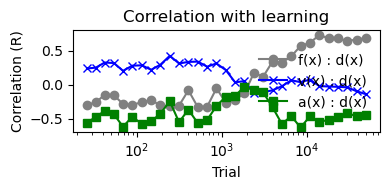

In [6]:
# Plot correlation with learning

plt.figure(figsize=(4,3))




plt.xscale('log')
plt.title('Correlation with learning')
plt.xlabel('Trial')
plt.ylabel('Correlation (R)')
plt.legend(frameon=False)
plt.tight_layout()

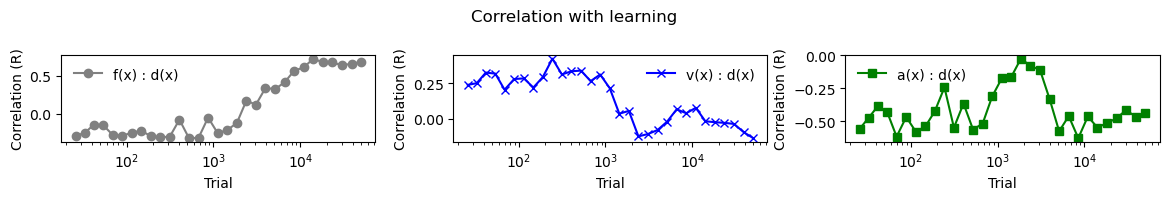

In [15]:
names = ['f','v','a']
plt.figure(figsize=(12,2))
for i in range(3):
    plt.subplot(1,3,i+1)
    if i ==0:
        plt.plot(trials, corrs_fd, marker='o', color='gray', label='f(x) : d(x)')
    elif i == 1:
        plt.plot(trials, corrs_vd, marker='x', color='blue', label='v(x) : d(x)')
    elif i == 2:
        plt.plot(trials, corrs_ad, marker='s', color='green', label='a(x) : d(x)')
    plt.xscale('log')
    plt.xlabel('Trial')
    plt.ylabel('Correlation (R)')
    plt.legend(frameon=False)
plt.suptitle('Correlation with learning')
plt.tight_layout()


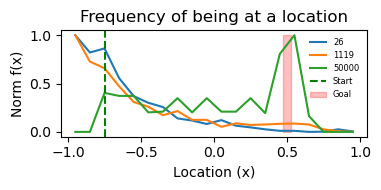

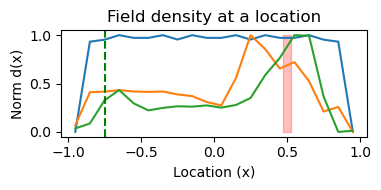

In [7]:
first, middle, last = trials[0], trials[len(trials) // 2], trials[-1]

plt.figure(figsize=(4,2))
for trial, visit, frequency in zip(trials, visits, freqs):
    if trial in [first, middle, last]:
        plt.plot(visit, (frequency-np.min(frequency))/(np.max(frequency)-np.min(frequency)),label=trial)
plt.xlabel('Location (x)')
plt.ylabel('Norm f(x)')
plt.axvline(startcoord[0],0,1, color='g',linestyle='--',label='Start')
plt.fill_betweenx(np.linspace(0,1), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Goal')
plt.legend(frameon=False, fontsize=6)
plt.title('Frequency of being at a location')
plt.tight_layout()

plt.figure(figsize=(4,2))
for trial, visit, density in zip(trials, visits, densities):
    if trial in [first, middle, last]:
        plt.plot(visit, (density-np.min(density))/(np.max(density)-np.min(density)),label=trial)
plt.xlabel('Location (x)')
plt.ylabel('Norm d(x)')
plt.axvline(startcoord[0],0,1, color='g',linestyle='--',label='Start')
plt.fill_betweenx(np.linspace(0,1), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Goal')
#plt.legend(frameon=False, fontsize=6)
plt.title('Field density at a location')
plt.tight_layout()

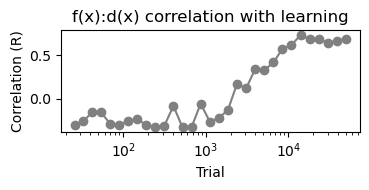

In [16]:
# correlation with learning

plt.figure(figsize=(4,2))

plt.plot(trials, corrs_fd, marker='o',color='gray')
plt.xscale('log')
plt.title('f(x):d(x) correlation with learning')
plt.xlabel('Trial')
plt.ylabel('Correlation (R)')
#plot_model_fit(trials, corrs, 'sigmoid')
plt.tight_layout()

In [9]:

xcorr_fxdx = np.zeros([num,num])
xcorr_vxdx = np.zeros([num,num])
xcorr_axdx = np.zeros([num,num])

for ts, strial in enumerate(trials):
    for t, trial in enumerate(trials):
        visit, frequency, density, velocity, acceleration, corr_fd, pval_fd, corr_vd, pval_vd, corr_ad, pval_ad = get_1D_fva_density_corr(allcoords, logparams, end=trial, gap=gap, bins=bins, end2=strial)
        xcorr_fxdx[ts, t] = corr_fd
        xcorr_vxdx[ts, t] = corr_vd
        xcorr_axdx[ts, t] = corr_ad
        

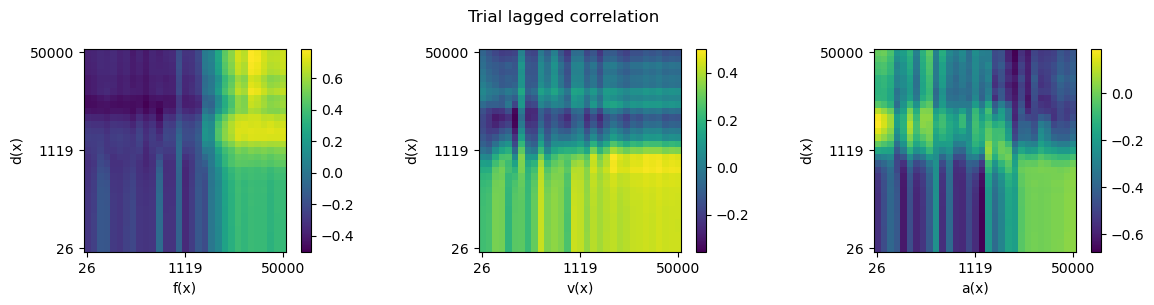

In [10]:
names = ['f','v','a']
plt.figure(figsize=(12,3))
for i, corr in enumerate([xcorr_fxdx, xcorr_vxdx, xcorr_axdx]):
    plt.subplot(1,3,i+1)
    plt.imshow(corr,origin='lower')
    plt.colorbar()
    ticks = np.linspace(0, num - 1, 3, dtype=int)
    tick_labels = [trials[0], trials[num // 2], trials[-1]]
    plt.xticks(ticks, tick_labels)
    plt.yticks(ticks, tick_labels)
    plt.xlabel(f'{names[i]}(x)')
    plt.ylabel('d(x)')
plt.suptitle('Trial lagged correlation')
plt.tight_layout()


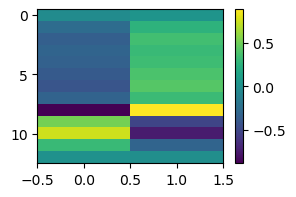

In [11]:
# place fields for forward & backward

policy = logparams[-1][3]
pcidx_forward = np.arange(npc)[policy[:,1]>0]
pcidx_backward = np.arange(npc)[policy[:,0]>0]
plt.figure(figsize=(3,2))
plt.imshow(policy,aspect='auto')
plt.colorbar()

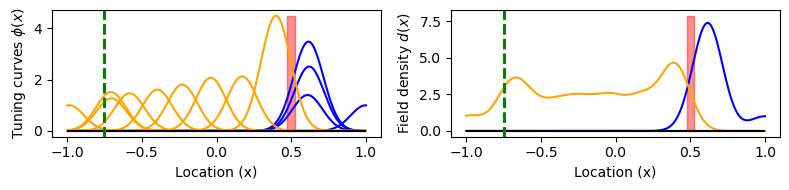

In [12]:
# plot place fields for different actions
xs = np.linspace(-1,1,1001)
pcacts = predict_batch_placecell(logparams[-1], xs)

# forward
plt.figure(figsize=(8,2))

for color, indx in zip(['blue','orange'],[pcidx_backward, pcidx_forward]):
    plt.subplot(121)
    for i in indx:
        plt.plot(xs, pcacts[:,i], color=color)
    plt.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k')
    plt.axvline(startcoord[0], color='g',linestyle='--',label='Start', linewidth=2)
    plt.fill_betweenx(np.linspace(0,np.max(pcacts)), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25)
    plt.ylabel('Tuning curves $\phi(x)$')
    plt.xlabel('Location (x)')

    plt.subplot(122)
    plt.plot(xs, np.sum(pcacts[:,indx],axis=1), color=color)
    plt.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k')
    plt.axvline(startcoord[0], color='g',linestyle='--',label='Start', linewidth=2)
    plt.fill_betweenx(np.linspace(0,np.max(np.sum(pcacts,axis=1))), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25)
    plt.ylabel('Field density $d(x)$')
    plt.xlabel('Location (x)')
    plt.tight_layout()


31.309999999999995
32.766666666666644
28.133333333333326
29.009999999999998
30.000000000000014
33.373333333333306
29.023333333333333
98.99999999999999


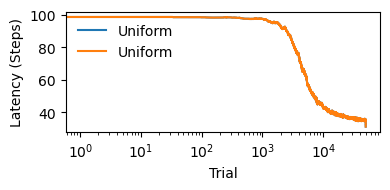

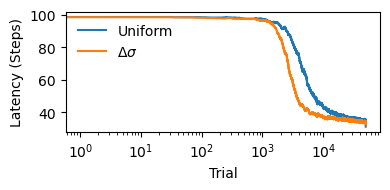

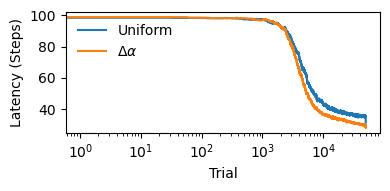

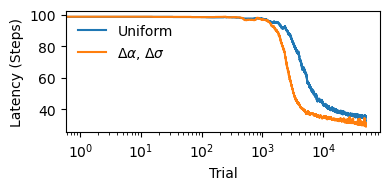

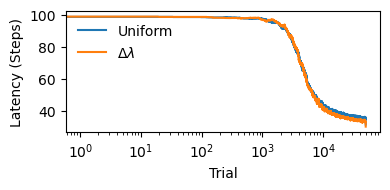

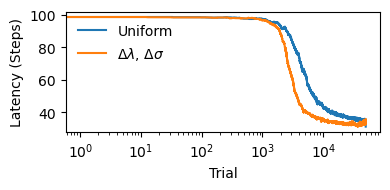

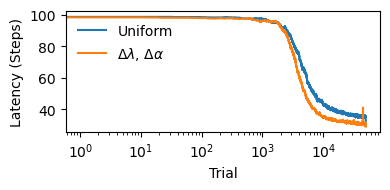

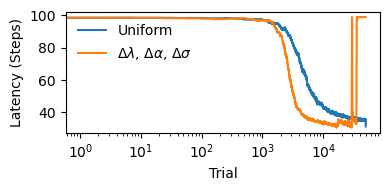

In [13]:
window_size = 300


exptname = f'1D_a2c_{npc}n_{seed}s_{episodes}e_{goalsize}gs_{actor_eta}plr_{0.0}llr_{0.0}alr_{0.0}slr_{0.0}ba_{0.0}bs'
[_, _, uni_latencys, _] = saveload('./data/'+exptname, 1, 'load')

names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
for llr in [0.0, 0.0001]:
    for alr in [0.0,0.0001]:
        for slr in [0.0,0.0001]:
            exptname = f'1D_a2c_{npc}n_{seed}s_{episodes}e_{goalsize}gs_{actor_eta}plr_{llr}llr_{alr}alr_{slr}slr_{ba}ba_{bs}bs'
            [logparams, allcoords, latencys, losses] = saveload('./data/'+exptname, 1, 'load')

            plt.figure(figsize=(4,2))

            unima = moving_average(uni_latencys, window_size)
            plt.plot(unima, label='Uniform')

            name_components = []
            if llr > 0:
                name_components.append(names_dict['llr'])
            if alr > 0:
                name_components.append(names_dict['alr'])
            if slr > 0:
                name_components.append(names_dict['slr'])
            name = ', '.join(name_components) if name_components else 'Uniform'


            ma = moving_average(latencys, window_size)
            plt.plot(ma, label=name)

            plt.xlabel('Trial')
            plt.ylabel('Latency (Steps)')
            print(ma[-1])
            plt.xscale('log')
            plt.legend(frameon=False)
            plt.tight_layout()
